In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


**Some information about the company**

Favorita Corporation and its commercial, industrial and real estate subsidiaries have a strong presence throughout the country. Its different lines of business and formats allows us to adapt our products, services and experiences offering to the local realities, according to your needs. Internationally, the Corporation’s subsidiaries have activities in six countries in the region, in addition to the ones in Ecuador.

In [2]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/49/9d/cfc8a3c8fd64b8e1dea423dd13b3e1b9da9c8886791fe8374760c9d36dac/darts-0.29.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
  Obtaining dependency information for nfoursid>=1.0.0 from https://files.pythonhosted.org/packages/0a/92/dda081df8d207b72e419ef5dbd6a861041ceabdc609557249f334555a619/nfoursid-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/d3/24/7fd322c05036e

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel, RNNModel, AutoARIMA
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from lightgbm import early_stopping
from tqdm import tqdm
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Dictionary to store DataFrames
dfs = {}

folder_path = '/kaggle/input/store-sales-time-series-forecasting/'

for file in filenames:
    file_path = folder_path + file
    df_name = file.split('.')[0]
    dfs[df_name] = pd.read_csv(file_path)
oil_df = dfs['oil']
sample_df = dfs['sample_submission']
holidays_df = dfs['holidays_events']
stores_df = dfs['stores']
train_df = dfs['train']
test_df = dfs['test']
transactions_df = dfs['transactions']

In [5]:
#Convert date to datetime format
holidays_df['date'] = pd.to_datetime(holidays_df['date'], format = "%Y-%m-%d")
oil_df['date'] = pd.to_datetime(oil_df['date'], format = "%Y-%m-%d")
transactions_df['date'] = pd.to_datetime(transactions_df['date'], format = "%Y-%m-%d")
train_df['date'] = pd.to_datetime(train_df['date'], format = "%Y-%m-%d")
test_df['date'] = pd.to_datetime(test_df['date'], format = "%Y-%m-%d")

In [6]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# upon reflection, remove all data prior to June 15, 2015 as the accuracy is similar with and without the data.
train_df = train_df.loc[train_df['date'] >= '2015-01-01']
holidays_df = holidays_df.loc[holidays_df['date'] >= '2015-01-01']
oil_df = oil_df.loc[oil_df['date'] >= '2015-01-01']
transactions_df = transactions_df.loc[transactions_df['date'] >= '2015-01-01']

## Analysis

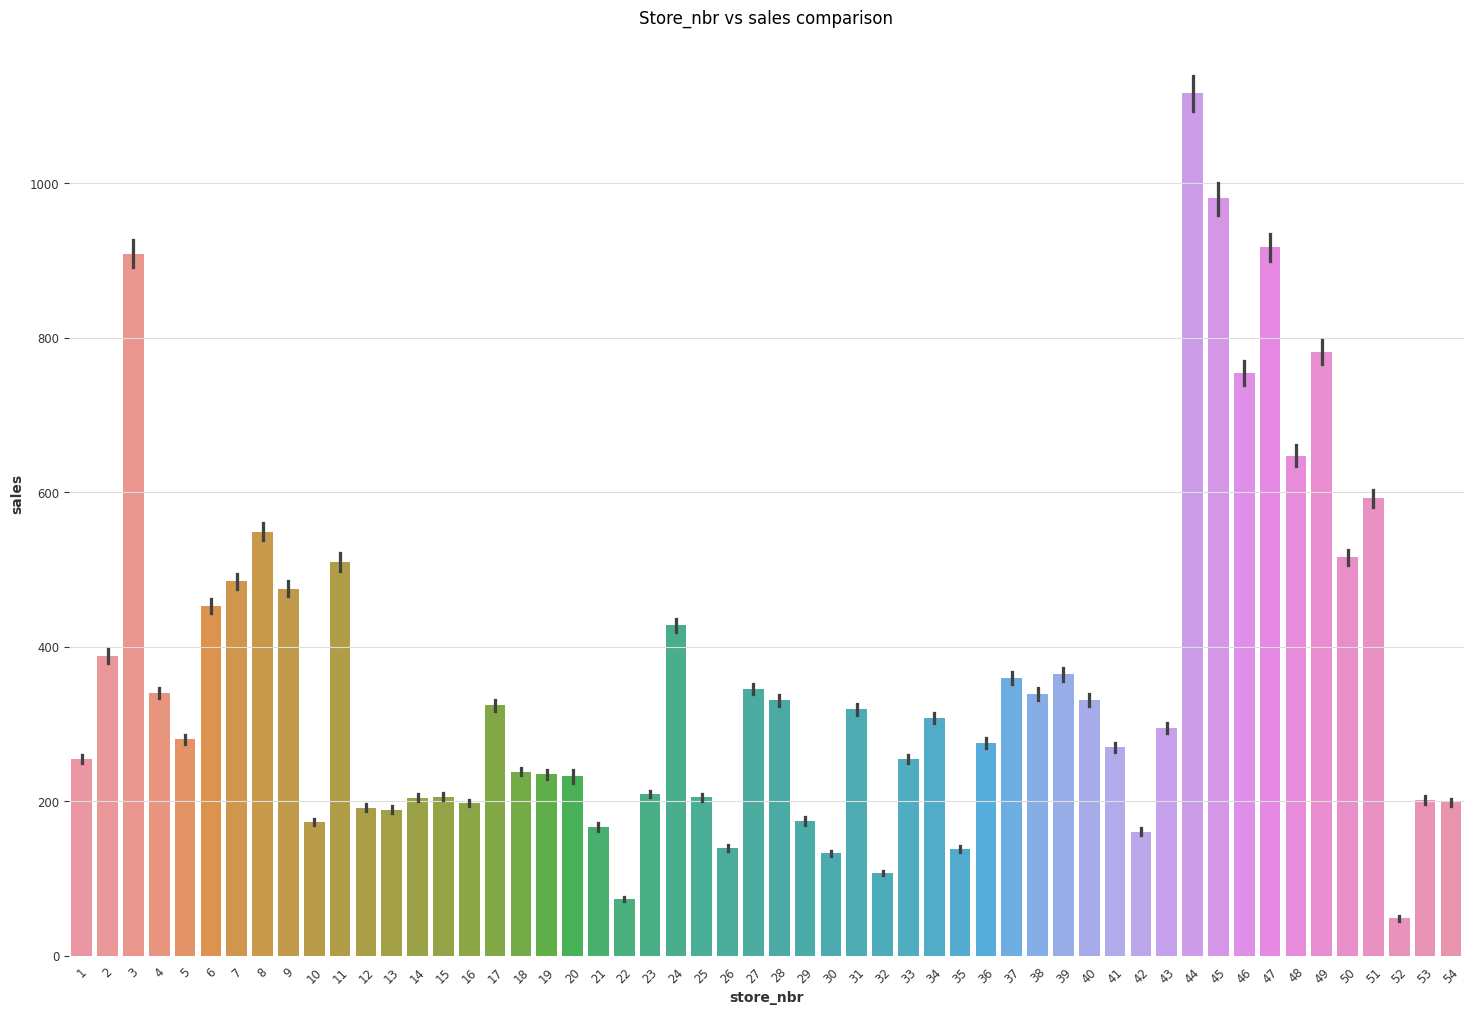

In [9]:
plt.rcParams['figure.figsize'] = (18,12)
plt.title('Store_nbr vs sales comparison')
sns.barplot(x='store_nbr',y='sales',data=train_df)
plt.xticks(rotation=45)
plt.show()

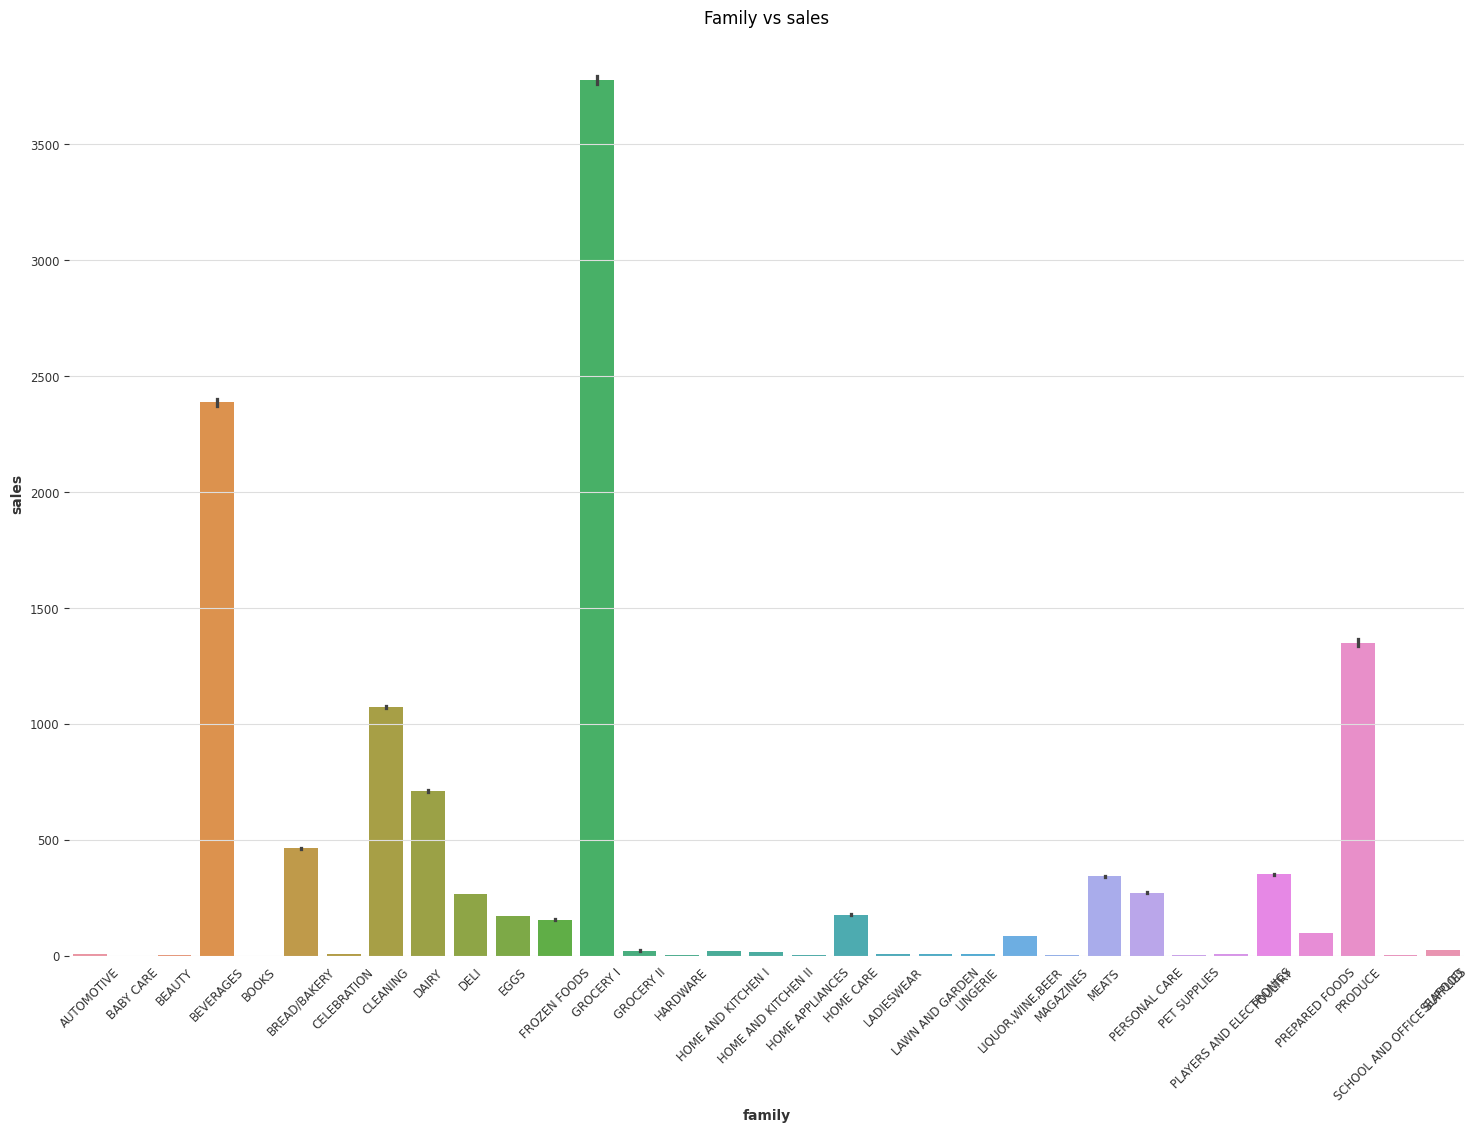

In [11]:
plt.title('Family vs sales')
sns.barplot(x='family',y='sales',data=train_df)
plt.xticks(rotation=45)
plt.show()

# Frozen Foods has the highest sales

In [14]:
train_merged = pd.merge(train_df, stores_df, on ='store_nbr')
train_merged = train_merged.sort_values(["store_nbr","family","date"])
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13


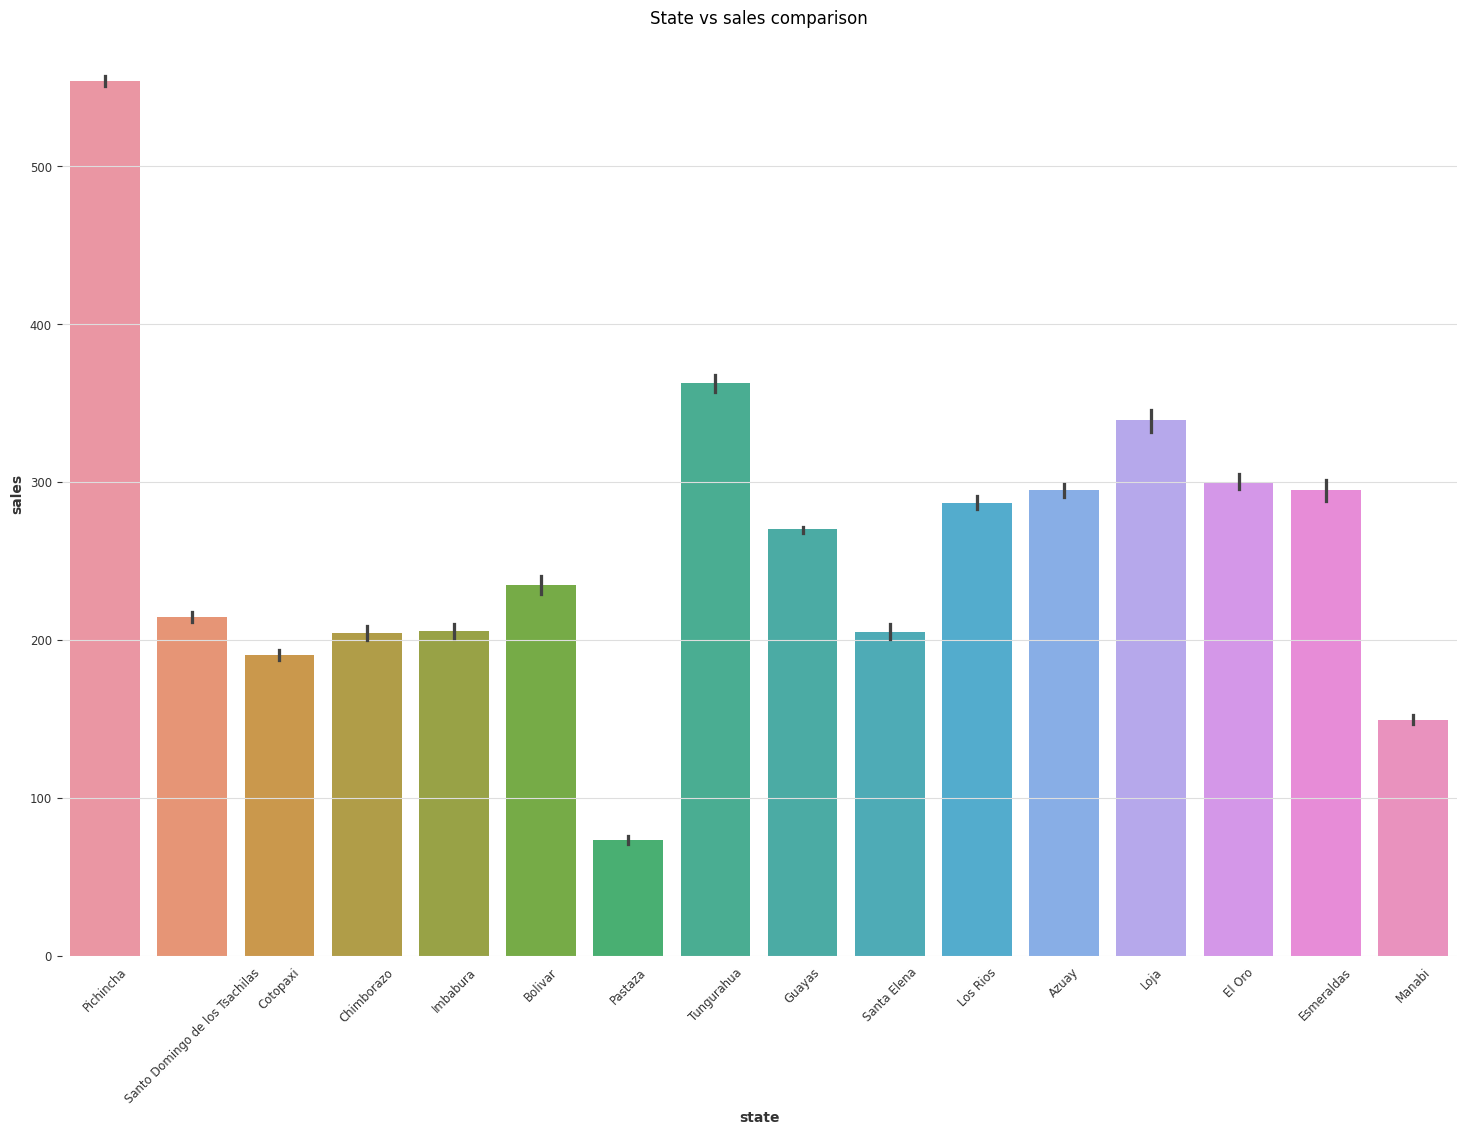

In [15]:
plt.title('State vs sales comparison')
sns.barplot(x='state',y='sales',data=train_merged)
plt.xticks(rotation=45)
plt.show()

# Pichincha has the highest sales

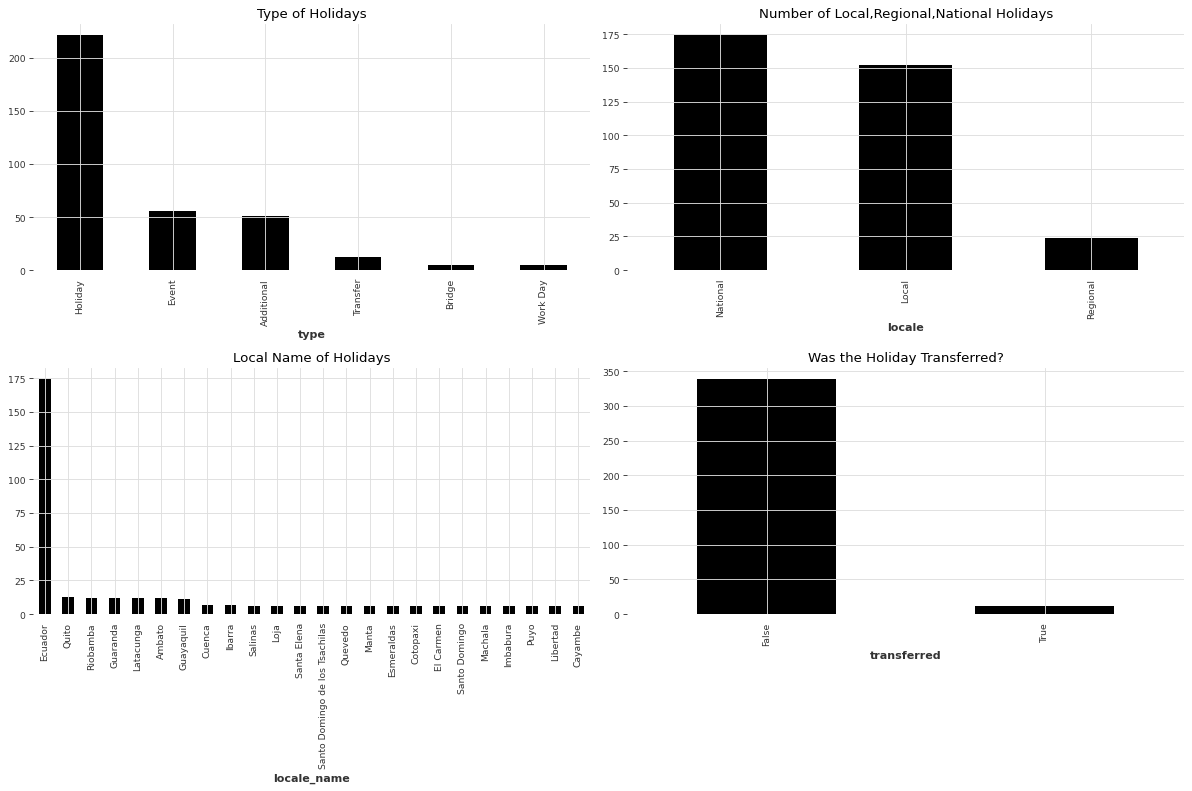

In [18]:
plt.figure(figsize=(15, 10), dpi= 80)
plt.subplot (2, 2, 1)
holidays_type = holidays_df['type'].value_counts().plot.bar().set_title('Type of Holidays')
plt.subplot (2, 2, 2)
holidays_locale = holidays_df['locale'].value_counts().plot.bar().set_title('Number of Local,Regional,National Holidays')
plt.subplot (2, 2, 3)
holidays_locale_name = holidays_df['locale_name'].value_counts().plot.bar().set_title('Local Name of Holidays')
plt.subplot (2, 2, 4)
holidays_transferred = holidays_df['transferred'].value_counts().plot.bar().set_title('Was the Holiday Transferred?')
plt. tight_layout ()
plt.show()

As we can see the most popular types are Holiday,National,Ecuador

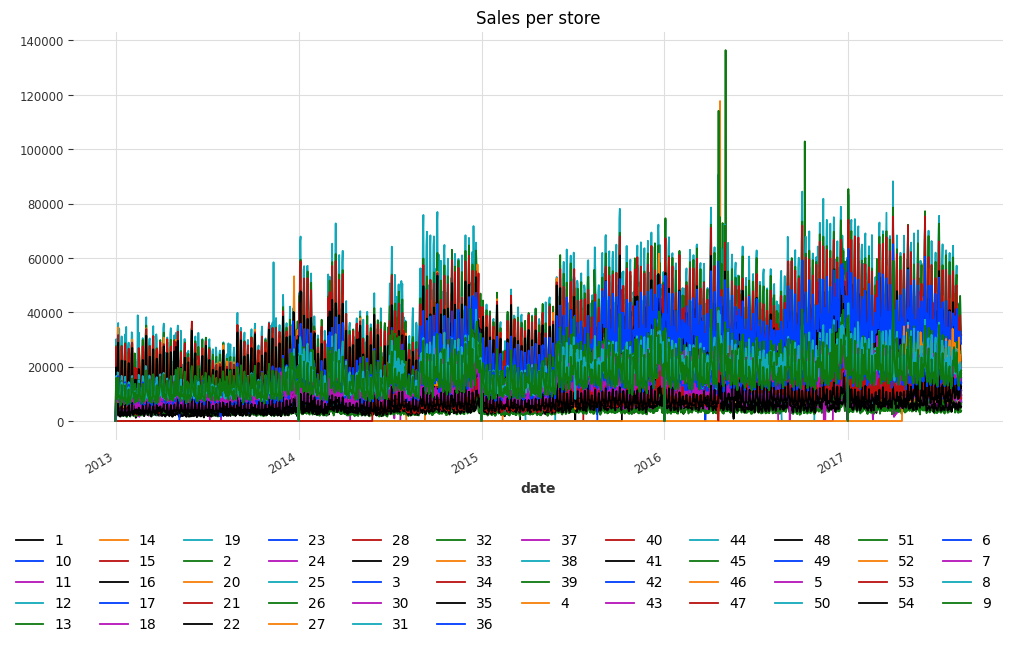

In [19]:
sale_store = train_merged.groupby(["date", "store_nbr"]).sales.sum().reset_index()
sale_store = sale_store.pivot(index='date', columns='store_nbr', values='sales')
sale_store.plot(figsize=(12, 6))
plt.title("Sales per store", fontsize=12)
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1, -.2), ncol=12)
plt.show()

on the chart we can observe a point with abnormal sales in 2016 for the certain stores

Timeline sales

In [30]:
## Select the date, days of the week, hours, month  !not used in calculations
merged_df_analysis = train_merged.copy()
merged_df_analysis['day_of_week'] = train_merged.date.dt.dayofweek
merged_df_analysis['day_of_year'] = train_merged.date.dt.dayofyear
merged_df_analysis['day_of_month'] = train_merged.date.dt.day
merged_df_analysis['year'] = train_merged.date.dt.year
merged_df_analysis['month'] = train_merged.date.dt.month
merged_df_analysis.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,day_of_week,day_of_year,day_of_month,year,month
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1,1,1,2013,1
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,2,2,2,2013,1
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,3,3,3,2013,1
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,4,4,4,2013,1
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,5,5,5,2013,1


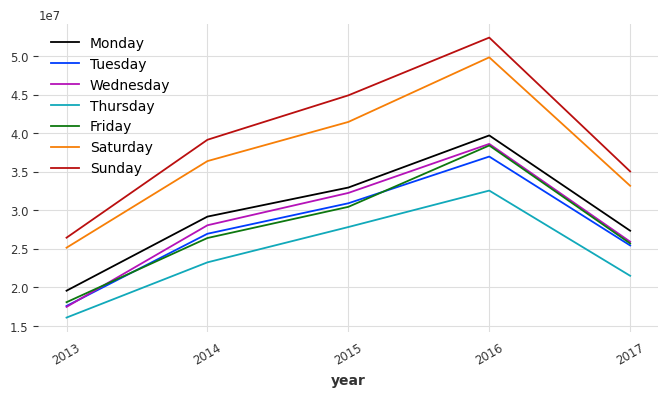

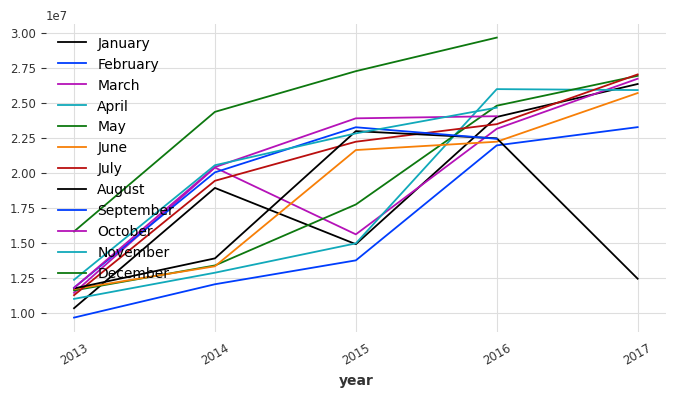

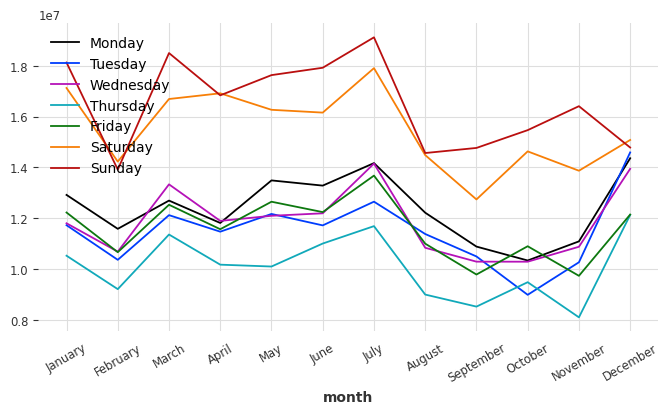

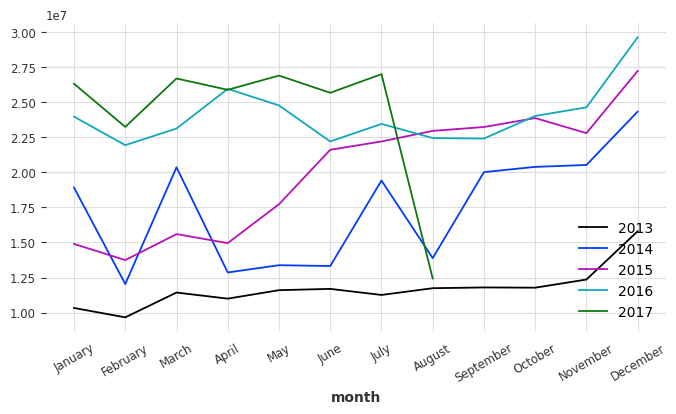

In [31]:
list_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_months = ['January','February','March','April','May','June','July','August','September','October','November','December'] 
list_years = ['2013','2014','2015','2016','2017']

frame1 = merged_df_analysis.groupby(['day_of_week', 'year'], as_index=False)['sales'].sum()
frame1 = frame1.pivot(index='year', columns='day_of_week', values='sales')
frame1.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_days)

frame4 = merged_df_analysis.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame4 = frame4.pivot(index='year', columns='month', values='sales')
frame4.plot(figsize=(8, 4))
plt.xticks(range(2013,2018,1),rotation=30)
plt.legend(list_months)

frame2 = merged_df_analysis.groupby(['day_of_week', 'month'], as_index=False)['sales'].sum()
frame2 = frame2.pivot(index='month', columns='day_of_week', values='sales')
frame2.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months,rotation=30)
plt.legend(list_days)

frame3 = merged_df_analysis.groupby(['month', 'year'], as_index=False)['sales'].sum()
frame3 = frame3.pivot(index='month', columns='year', values='sales')
frame3.plot(figsize=(8, 4))
plt.xticks(range(1,13), labels=list_months, rotation=30)
plt.legend(list_years)


plt.show()

We observe that year-over-year sales trends consistently follow similar patterns throughout the weeks, showing a gradual increase over time. While the monthly data also indicates an upward trend, the correlation is less pronounced compared to the weekly analysis. However, the insights from the last two graphs do not provide any definitive conclusions.

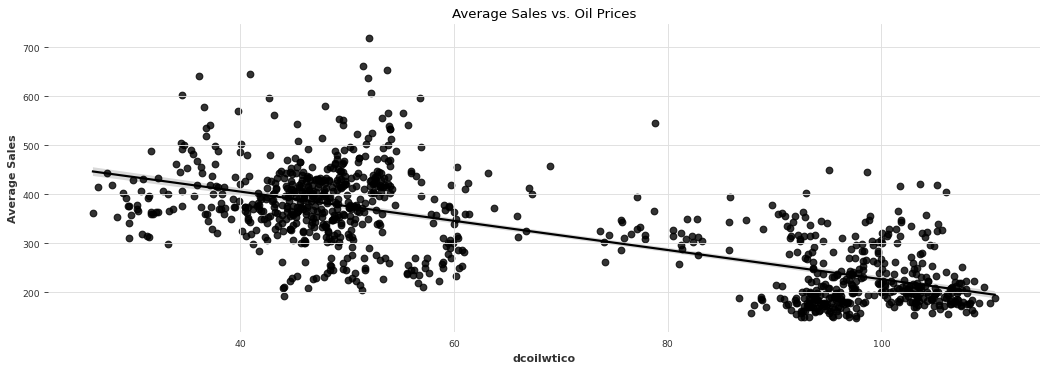

In [36]:
merged_oil_df = pd.merge(train_df, oil_df, on='date', how='left')
merged_oil_df = merged_oil_df.groupby(['dcoilwtico'], as_index=False)['sales'].mean()

plt.figure(figsize=(16, 5), dpi= 80)
sns.regplot(x=merged_oil_df.dcoilwtico, y=merged_oil_df.sales)
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Oil Prices")
plt.show()

There is some correlation between the oil prices and the sales

Text(0.5, 1.0, 'Average Sales vs. Store Transactions')

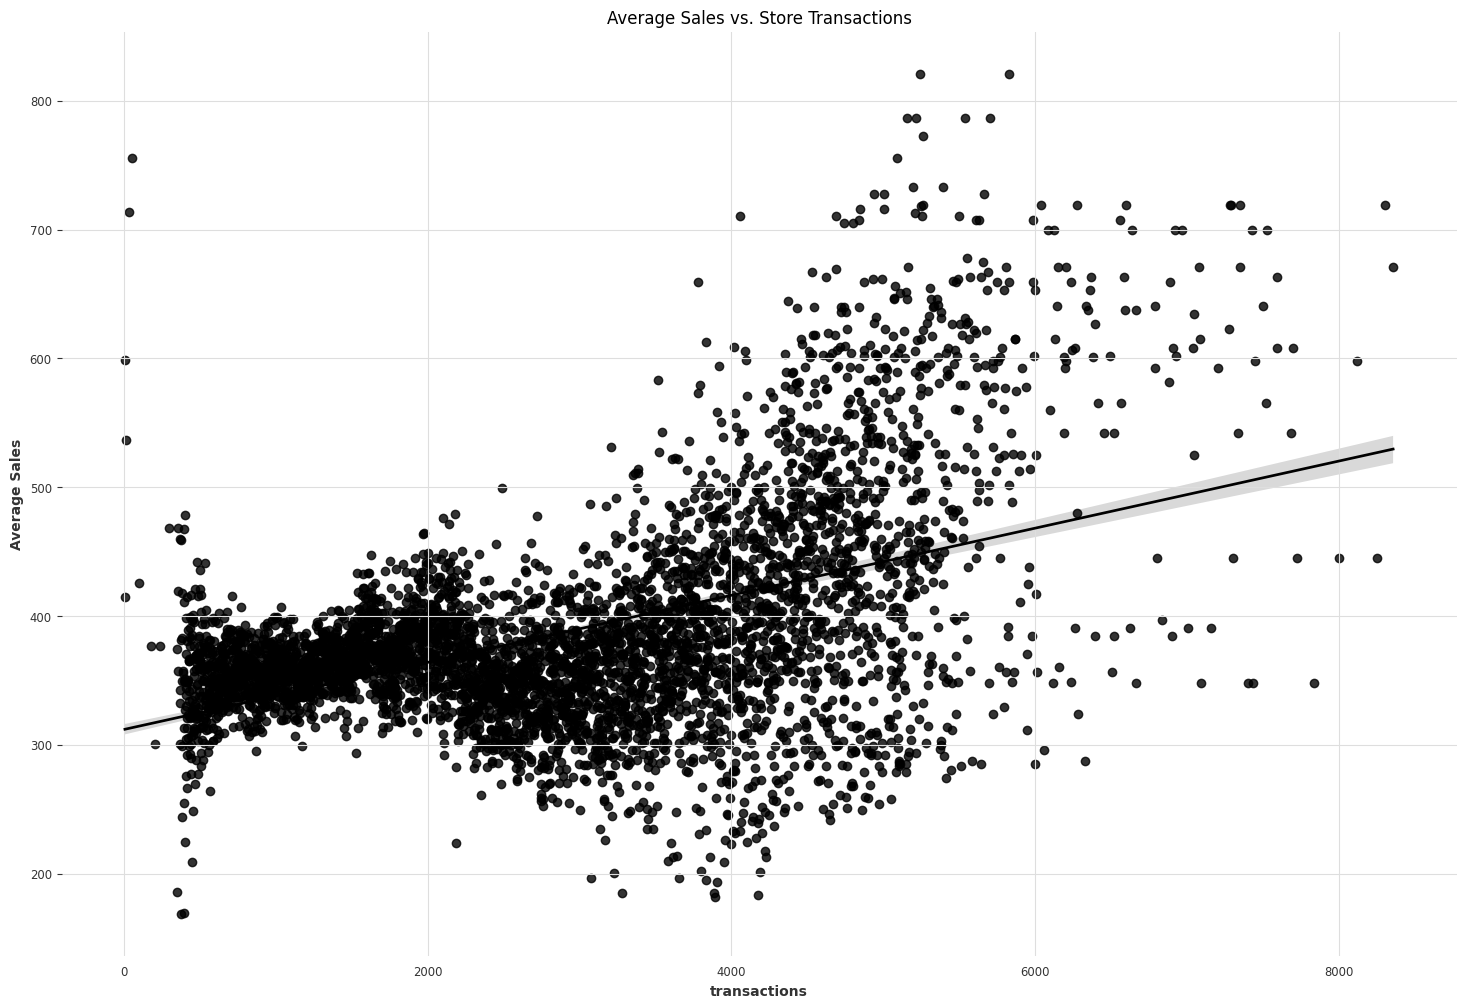

In [38]:
merged_tran_df = pd.merge(train_df, transactions_df, on='date', how='left')
merged_tran_df = merged_tran_df.groupby(['transactions'], as_index=False)['sales'].mean()

sns.regplot(x=merged_tran_df.transactions, y=merged_tran_df.sales)
plt.xlabel("transactions")
plt.ylabel("Average Sales")
plt.title("Average Sales vs. Store Transactions")

In [21]:
# oil_df.oil = oil_df.oil.interpolate(method="linear", limit_direction="both")
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [22]:
family_list = train_df['family'].unique()
store_list = stores_df['store_nbr'].unique()

Zero sales

In [23]:
holidays_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


## Pre-Processing

Identify combinations of store number and product family that have zero sales.


In [24]:
zero_sales_df = train_df.groupby(["store_nbr","family"]).sales.sum().reset_index()
zero_sales_df = zero_sales_df[zero_sales_df.sales == 0]

**Methods**

Our objective is to predict for each family in each store the number of future sales. There are 33 families for 54 stores.

From there, several routes can be taken.

**Method 1**: The most obvious one is to train a Machine Learning model on our dataset. On the 1782 time series.
This method would allow us to use a maximum of data to train our model. This could be used for a global and generalized prediction.
This method has given us 0.45 - 0.5 Mean Square Error using various models which is more than the second method. 

**Method 2**: Train a Machine Learning model for each product family. This has given us a better performance with lesser error.

In this notebook method 2 has been implemented.

In the following lines of code, we extract the TimeSeries of the 54 stores for each family.

These TimeSeries will group the sales by family, the date of each sale, but also the dependent covariates (indicated with group_cols and static_cols) of these sales: store_nbr, family, city, state, type, cluster :

**Covariates**¶
A covariate is a variable that helps to predict a target variable.

This covariate can be dependent on the target variable. For example, the type of store, type, where the sales are made. But it can also be independent. For example, the price of oil on the day of the sale of a product.

This covariate can be known in advance, for example in our dataset we have the price of oil from January 1, 2013 to August 31, 2017. In this case, we talk about a **future covariate**.

There are also **past covariates**. These are covariates that are not known in advance. For example in our dataset, the transactions are known for the dates January 1, 2013 to August 15, 2017.

In this section, we are creating a dictionary of time series data for each product family in our dataset. Each entry in the dictionary corresponds to a specific product family and contains a list of time series, one for each store. 

In [25]:
family_TS_dict = {}

for family in family_list:
  df_family = train_merged.loc[train_merged['family'] == family]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
 
  #Looping through this list of timeseries to cast the data type of each time series to float
  for ts in list_of_TS_family:
    ts = ts.astype(np.float32)
    
  #time series sorted by stores.
  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

Setting up and applying a data transformation pipeline for the time series data of each product family. The goal is to prepare the data for further analysis and modeling by filling missing values, encoding categorical variables, applying a logarithmic transformation, and scaling the data. 

In [26]:
family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

Generate various temporal covariates that will be used to enrich our time series data. These covariates include attributes like the year, month, day, day of the year, weekday, week of the year, and a linear time step. These additional features will help in capturing seasonality, trends, and other temporal patterns in the data. 

In [27]:

full_time_period = pd.date_range(start='2015-01-01', end='2017-08-31', freq='D')


year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

In [26]:
#Normalizing this data
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

**Oil**

We process the oil price data by filling missing values, scaling, and applying a logarithmic transformation. We also calculate moving averages to smooth out short-term fluctuations and highlight longer-term trends in oil prices.

As said before, the price of oil is a future covariate because it is known in advance.

Here, we will not simply extract the daily oil price but we will calculate the moving average.

The moving average in X, is an average of the current value and the X-1 previous values of a time series.

For example the moving average in 7 is the average of (t + t-1 + … + t-6) / 7. It is calculated at each t, that’s why it is called “moving”.

Calculating the moving average allows us to remove the momentary fluctuations of a value and thus to accentuate the long-term trends.

The moving average is used in trading, but more generally in Time Series Analysis.

In the following code, we calculate the moving average in 7 and 28 of the oil price. And of course, we apply a normalization :

In [27]:
# Oil Price

oil = TimeSeries.from_dataframe(oil_df, 
                                time_col = 'date', 
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil = oil.astype(np.float32)
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler, log_transformer])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

Cleaning Holiday Descriptions:

The function process_holiday is defined to clean holiday descriptions. It removes words related to city and state names, as well as certain common terms. If the description contains "futbol", it's labeled as a football-related holiday.
The apply function is used to apply this cleaning function to the holiday descriptions column in the holidays_df DataFrame.
Removing Transferred Holidays:

Transferred holidays are filtered out by selecting only rows where the transferred column is False.
Saturdays Designated as Work Days:

Work days designated on Saturdays are identified and stored in the work_days DataFrame. These are marked with a value of 1 in the work_day column.
Categorizing Local Holidays:

Local holidays are extracted from the DataFrame, and their descriptions are one-hot encoded.
Duplicate entries are removed, and the DataFrame is reorganized to include only necessary columns.
Categorizing Regional Holidays:

Similar to local holidays, regional holidays are extracted and their descriptions are one-hot encoded.
The DataFrame is reorganized to include state-level information and renamed columns for clarity.
Categorizing National Holidays:

National holidays are extracted and their descriptions are one-hot encoded.
Duplicate entries are removed, and the DataFrame is reorganized to include only necessary columns.
Some holidays may have different descriptions but fall on the same date; these are grouped together.
Column names are shortened for visualization purposes.

In [29]:
national_locale_name = sorted(holidays_df[holidays_df.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(holidays_df[holidays_df.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(holidays_df[holidays_df.locale.eq("Local")].locale_name.unique().tolist())

In [30]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores_df.city.str.lower()) | set(stores_df.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [31]:
holidays_df.description = holidays_df.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holidays_df.head()

/tmp/ipykernel_42/959457152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_df.description = holidays_df.apply(


,date,type,locale,locale_name,description,transferred
159,2015-01-01,Holiday,National,Ecuador,primer dia ano,False
160,2015-01-02,Bridge,National,Ecuador,primer dia ano,False
161,2015-01-10,Work Day,National,Ecuador,primer dia ano,False
162,2015-02-16,Holiday,National,Ecuador,carnaval,False
163,2015-02-17,Holiday,National,Ecuador,carnaval,False


In [35]:
# remove transferred holidays
holidays_df = holidays_df[holidays_df.transferred.eq(False)]

### Saturdays designated as work days ###
work_days = holidays_df[holidays_df.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holidays_df = holidays_df[holidays_df.type!="Work Day"].reset_index(drop=True)

### local holidays (city level) ###
local_holidays = holidays_df[holidays_df.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

### regional holidays (state level) ###
regional_holidays = holidays_df[holidays_df.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

### national holidays ###
national_holidays = holidays_df[holidays_df.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2015-01-01,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2015-01-02,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2015-02-16,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2015-02-17,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2015-04-03,0,0,0,0,0,0,0,0,0,0,0,0,1


All the different holidays are assigned to each store. Basically everything will be same for all the stores except local holiday. Returns list of holidays per store. 
Eg. np.where(..., 1, 0): If the condition is true for a particular row, the corresponding value in the "national_holiday" column is set to 1; otherwise, it's set to 0.

In [36]:
def holiday_list(df_stores):

    listofseries = []
    
    for i in range(0,len(df_stores)):
            
            df_holiday_dummies = pd.DataFrame(columns=['date'])
            df_holiday_dummies["date"] = holidays_df["date"]
            
            df_holiday_dummies["national_holiday"] = np.where(((holidays_df["type"] == "Holiday") & (holidays_df["locale"] == "National")), 1, 0)

            df_holiday_dummies["earthquake_relief"] = np.where(holidays_df['description'].str.contains('Terremoto Manabi'), 1, 0)

            df_holiday_dummies["christmas"] = np.where(holidays_df['description'].str.contains('Navidad'), 1, 0)

            df_holiday_dummies["football_event"] = np.where(holidays_df['description'].str.contains('futbol'), 1, 0)

            df_holiday_dummies["national_event"] = np.where(((holidays_df["type"] == "Event") & (holidays_df["locale"] == "National") & (~holidays_df['description'].str.contains('Terremoto Manabi')) & (~holidays_df['description'].str.contains('futbol'))), 1, 0)

            df_holiday_dummies["work_day"] = np.where((holidays_df["type"] == "Work Day"), 1, 0)

            df_holiday_dummies["local_holiday"] = np.where(((holidays_df["type"] == "Holiday") & ((holidays_df["locale_name"] == df_stores['state'][i]) | (holidays_df["locale_name"] == df_stores['city'][i]))), 1, 0)
                     
            listofseries.append(df_holiday_dummies)

    return listofseries

In [37]:
def remove_0_and_duplicates(holiday_list):

    listofseries = []
    
    for i in range(0,len(holiday_list)):
            
            df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
            
            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                                   'christmas':'max', 'football_event':'max', 
                                   'national_event':'max', 'work_day':'max', 
                                   'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries

Making a time series for each store. So 54 time series objects.

In [38]:
def holiday_TS_list_54(holiday_list):

    listofseries = []
    
    for i in range(0,54):
            
            holidays_TS = TimeSeries.from_dataframe(list_of_holidays_per_store[i], 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
            holidays_TS = holidays_TS.slice(pd.Timestamp('20150101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries

In [39]:
list_of_holidays_per_store = holiday_list(stores_df)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)   
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, log_transformer, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

In [36]:
df_promotion = pd.concat([train_df, test_df], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
  df_family = df_promotion.loc[df_promotion['family'] == family]

  list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')
  
  for ts in list_of_TS_promo:
    ts = ts.astype(np.float32)

  family_promotion_dict[family] = list_of_TS_promo

In [38]:
promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
  promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   

  promo_pipeline = Pipeline([promo_filler,
                             log_transformer,
                             promo_scaler])
  
  promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])
  
  # Moving Averages for Promotion Family Dictionaries
  promo_moving_average_7 = MovingAverageFilter(window=7)
  promo_moving_average_28 = MovingAverageFilter(window=28)

  promotion_covs = []

  for ts in promotion_transformed:
    ma_7 = promo_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
    ma_28 = promo_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
    promo_and_mas = ts.stack(ma_7).stack(ma_28)
    promotion_covs.append(promo_and_mas)

  promotion_transformed_dict[key] = promotion_covs

100%|██████████| 33/33 [01:32<00:00,  2.81s/it]


In summary we have 
* promotion - 3 columns (7, 28 moving averages and onpromotion) and 1782 time series objects, that is, 1 TS for each family per store
* sales - 1782 time series objects, that is, 1 TS for each family per store
* oil - 1 TS object and 3 columns (7, 28 moving averages and onpromotion)


### Grouping covariates

In [39]:
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

In [40]:
store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)  
  store_covariates_future.append(stacked_covariates)

In [41]:
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]

  future_covariates_dict[key] = covariates_future

100%|██████████| 33/33 [00:05<00:00,  5.86it/s]


## Transactions - Past covariates

In [45]:
# compute total sales for each store
store_sales = train_df.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transactions_df = transactions_df.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transactions_df.loc[transactions_df.sales.eq(0), "transactions"] = 0.
transactions_df = transactions_df.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transactions_df.transactions = transactions_df.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [46]:
transactions_df.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                transactions_df,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

from datetime import datetime, timedelta

transactions_list_full = []

for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    end_time = (ts.start_time() - timedelta(days=1))
    delta = end_time - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'), 
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
    ts = zero_series.append(ts)
    ts = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions")
    transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, log_transformer, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

In [ ]:
LGBM_Models_Submission = {}

display("Training...")

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]
      

  LGBM_Model_Submission = LightGBMModel(lags = 63,
                                        lags_future_covariates = (14,1),
                                        lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22],
                                        output_chunk_length=3,
                                        random_state=2022,
                                        gpu_use_dp= "false",
                                        )
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed
                           )

#Create and fit the RNN model
#   rnn_model = RNNModel(input_chunk_length=50, output_chunk_length=1, n_epochs=20)
#   rnn_model.fit(train_sliced,future_covariates=TCN_covariates)
#   LGBM_Models_Submission[family] = rnn_model

  LGBM_Models_Submission[family] = LGBM_Model_Submission

In [ ]:
display("Predictions...")

LGBM_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family]
  LGBM_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed
                                         )
  
  LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

In [ ]:
LGBM_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

  LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

In [ ]:
df_test_dropped = test_df.drop(['onpromotion'], axis=1)
df_test_sorted = df_test_dropped.sort_values(by=['store_nbr','family'])

In [ ]:
for family in tqdm(LGBM_Forecasts_Families_back_Submission):
  for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
    if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
        LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

listofseries = []

for store in tqdm(range(0,54)):
  for family in family_list:
      oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted

In [ ]:
# submission_kaggle.to_csv('/kaggle/working/submission.csv', index=False)

### Multiple models

In [ ]:
model_params = [
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

1. **Model Training**:
   - Iterate over a list of model parameters (`model_params`), containing configurations for the LightGBM models.
   - For each set of parameters, train LightGBM model for each family of products. The training data is sliced based on future covariates, and past transaction data is used as additional covariates.
   - The trained models are stored in a dictionary (`LGBM_Models_Submission`).

2. **Making Predictions**:
   - After training the models, it predicts future values for each family of products.
   - Again, the data is sliced based on future covariates, and past transaction data is used as additional covariates.
   - The forecasts are stored in another dictionary (`LGBM_Forecasts_Families_Submission`).

3. **Inverse Transformation**:
   - The forecasts are transformed back to their original scale using the inverse transformation pipeline stored in `family_pipeline_dict`.

4. **Preparing Submission**:
   - Negative forecasts are set to zero.
   - The forecasts are concatenated with test data and sorted by the `id`.
   - Unnecessary columns are dropped, and the 'fcast' column is renamed to 'sales'.
   - Finally, the prepared forecasts are appended to a list (`submission_kaggle_list`), to be used for submission to Kaggle.

In [ ]:
submission_kaggle_list = []

for params in model_params:

  LGBM_Models_Submission = {}

  display("Training...")

  for family in tqdm(family_list):

    # Define Data for family
    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family] 
    TCN_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    LGBM_Model_Submission = LightGBMModel(lags = params["lags"],
                                          lags_future_covariates = params["lags_future_covariates"],
                                          lags_past_covariates = params["lags_past_covariates"],
                                          output_chunk_length=3,
                                          random_state=2022,
                                          gpu_use_dp= "false")
      
    LGBM_Model_Submission.fit(series=train_sliced, 
                          future_covariates=TCN_covariates,
                          past_covariates=transactions_transformed
                             )

    LGBM_Models_Submission[family] = LGBM_Model_Submission
    
  display("Predictions...")


  LGBM_Forecasts_Families_Submission = {}

  for family in tqdm(family_list):

    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family]
    LGBM_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                          series=train_sliced,
                                          future_covariates=LGBM_covariates,
                                          past_covariates=transactions_transformed
                                                          )
    
    LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

  # Transform Back

  LGBM_Forecasts_Families_back_Submission = {}

  for family in tqdm(family_list):

    LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

  # Prepare Submission in Correct Format

  for family in tqdm(LGBM_Forecasts_Families_back_Submission):
    for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
      if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
          LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
          
  listofseries = []

  for store in tqdm(range(0,54)):
    for family in family_list:
        oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
        oneforecast.columns = ['fcast']
        listofseries.append(oneforecast)

  df_forecasts = pd.concat(listofseries) 
  df_forecasts.reset_index(drop=True, inplace=True)

  # No Negative Forecasts
  df_forecasts[df_forecasts < 0] = 0
  forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
  forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

  # Submission
  submission_kaggle_list.append(forecasts_kaggle_sorted)

In [ ]:
df_sample_submission = dfs['sample_submission']

In [ ]:
df_sample_submission['sales'] = (submission_kaggle[['sales']]+submission_kaggle_list[0][['sales']]+submission_kaggle_list[1][['sales']]+submission_kaggle_list[2][['sales']])/4

In [ ]:
# Add zero sales
for index, row in zero_sales_df.iterrows():
    mask = (test_df['store_nbr'] == row['store_nbr']) & (test_df['family'] == row['family'])
    df_sample_submission.loc[mask, 'sales'] = 0

In [ ]:
df_sample_submission.to_csv('/kaggle/working/submission.csv', index=False)